# Fine-tuning with a specific loss function

When fine-tuning, the model trains on your dataset to tailor its predictions to your particular scenario. As such, it is possible to specify the loss function used during fine-tuning.

Specifically, you can choose from:<br>
- `"default"` - a proprietary loss function that is robust to outliers<br>
- `"mae"` - mean absolute error<br>
- `"mse"` - mean squared error<br>
- `"rmse"` - root mean squared error<br>
- `"mape"` - mean absolute percentage error<br>
- `"smape"` - symmetric mean absolute percentage error

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
#| hide
from nixtla.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/11_loss_function_finetuning')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/11_loss_function_finetuning.ipynb)

In [ ]:
#| hide
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

False

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
nixtla_client = NixtlaClient()

## 2. Load data

Let's fine-tune the model on a dataset using the mean absolute error (MAE).

For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.insert(loc=0, column='unique_id', value=1)

df.head()

,unique_id,timestamp,value
0,1,1949-01-01,112
1,1,1949-02-01,118
2,1,1949-03-01,132
3,1,1949-04-01,129
4,1,1949-05-01,121


## 3. Fine-tuning with Mean Absolute Error
Let's fine-tune the model on a dataset using the Mean Absolute Error (MAE).

For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
timegpt_fcst_finetune_mae_df = nixtla_client.forecast(
    df=df, 
    h=12, 
    finetune_steps=10,
    finetune_loss='mae',   # Set your desired loss function
    time_col='timestamp', 
    target_col='value',
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


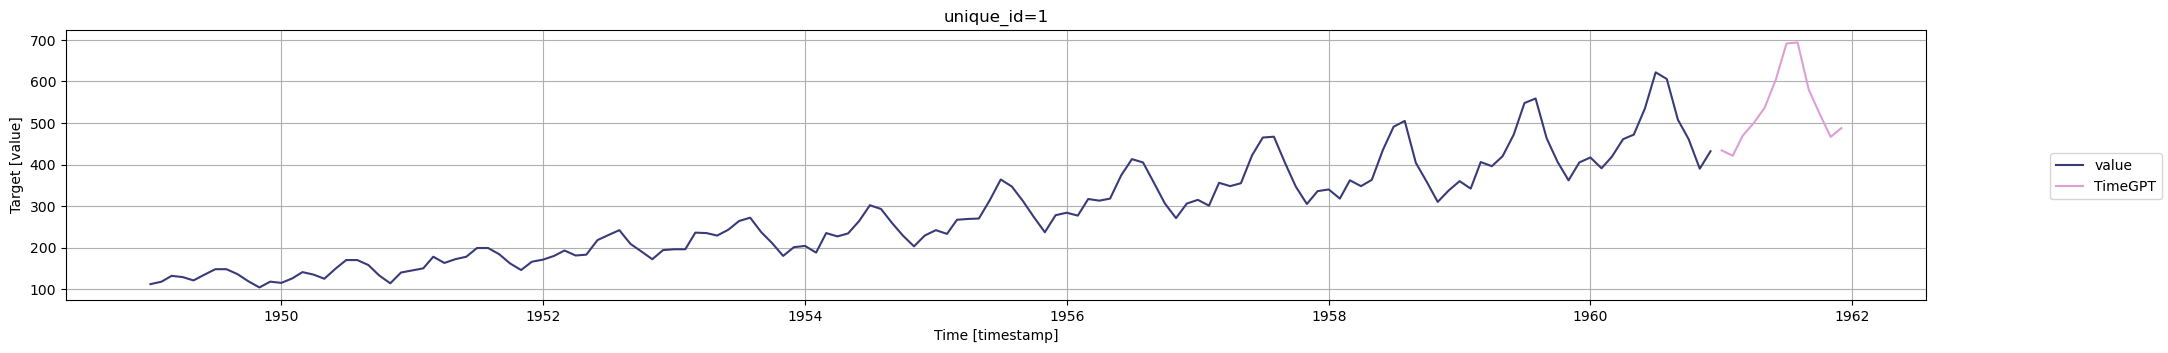

In [ ]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_mae_df, 
    time_col='timestamp', target_col='value',
)

Now, depending on your data, you will use a specific error metric to accurately evaluate your forecasting model's performance.  Below is a non-exhaustive guide on which metric to use depdending on your use case.<br>

Below is a non-exhaustive guide on which metric to use depending on your use case.

**Mean absolute error (MAE)**<br>

<img src="https://latex.codecogs.com/png.image?\dpi{110}\bg{white}\mathbf{y}_{\tau},\mathbf{\hat{y}}_{\tau})=\frac{1}{H}\sum^{t&plus;H}_{\tau=t&plus;1}|y_{\tau}-\hat{y}_{\tau}|">

- Robust to outliers<br>
- Easy to understand<br>
- You care equally about all error sizes<br>
- Same units as your data<br>

**Mean squared error (MSE)**<br>

<img src="https://latex.codecogs.com/png.image?\dpi{110}\bg{white}\mathrm{MSE}(\mathbf{y}_{\tau},\mathbf{\hat{y}}_{\tau})=\frac{1}{H}\sum^{t&plus;H}_{\tau=t&plus;1}(y_{\tau}-\hat{y}_{\tau})^{2}">

- You want to penalize large errors more than small ones<br>
- Sensitive to outliers<br>
- Used when large errors must be avoided<br>
- *Not* the same units as your data<br>

**Root mean squared error (RMSE)**<br>

<img src="https://latex.codecogs.com/png.image?\dpi{110}\bg{white}\mathrm{RMSE}(\mathbf{y}_{\tau},\mathbf{\hat{y}}_{\tau})=\sqrt{\frac{1}{H}\sum^{t&plus;H}_{\tau=t&plus;1}(y_{\tau}-\hat{y}_{\tau})^{2}}">


- Brings the MSE back to original units of data<br>
- Penalizes large errors more than small ones<br>

**Mean absolute percentage error (MAPE)**<br>

<img src="https://latex.codecogs.com/png.image?\dpi{110}\bg{white}\mathrm{MAPE}(\mathbf{y}_{\tau},\mathbf{\hat{y}}_{\tau})=\frac{1}{H}\sum^{t&plus;H}_{\tau=t&plus;1}\frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|}">

- Easy to understand for non-technical stakeholders<br>
- Expressed as a percentage<br>
- Heavier penalty on positive errors over negative errors<br>
- To be avoided if your data has values close to 0 or equal to 0<br>


**Symmmetric mean absolute percentage error (sMAPE)**<br>

<img src="https://latex.codecogs.com/png.image?\dpi{110}\bg{white}\mathrm{SMAPE}(\mathbf{y}_{\tau},\mathbf{\hat{y}}_{\tau})=\frac{1}{H}\sum^{t&plus;H}_{\tau=t&plus;1}\frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|&plus;|\hat{y}_{\tau}|}">


- Fixes bias of MAPE<br>
- Equally senstitive to over and under forecasting<br>
- To be avoided if your data has values close to 0 or equal to 0<br>


With TimeGPT, you can choose your loss function during fine-tuning as to maximize the model's performance metric for your particular use case.  Let's run a small experiment to see how each loss function improves their associated metric when compared to the default setting.

In [ ]:
train = df[:-36]
test = df[-36:]

In [ ]:
losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

test = test.copy()

for loss in losses:
    preds_df = nixtla_client.forecast(
    df=train, 
    h=36, 
    finetune_steps=10,
    finetune_loss=loss,
    time_col='timestamp', 
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_{loss}'] = preds

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
#| hide
test.head()

,unique_id,timestamp,value,TimeGPT_default,TimeGPT_mae,TimeGPT_mse,TimeGPT_rmse,TimeGPT_mape,TimeGPT_smape
108,1,1958-01-01,340,347.134094,341.943970,347.450745,346.888367,356.781281,341.738251
109,1,1958-02-01,318,345.739746,343.295227,346.430359,345.676300,354.055420,345.023163
110,1,1958-03-01,362,394.611450,391.062592,395.355957,394.532593,396.767273,392.466675
111,1,1958-04-01,348,404.133545,400.497070,404.335083,403.427429,396.014648,402.627441
112,1,1958-05-01,363,421.236542,418.358673,422.227295,421.627625,410.181091,422.384644


Great! We have predictions from TimeGPT using all the different loss functions. We can evaluate the performance using their associated metric and measure the improvement.

In [ ]:
from utilsforecast.losses import mae, mse, rmse, mape, smape

loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

pct_improv = []

for loss in losses[1:]:
    evaluation = loss_fct_dict[f'{loss}'](test, models=['TimeGPT_default', f'TimeGPT_{loss}'], id_col='unique_id', target_col='value')
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

In [ ]:
data = {
    'mae': pct_improv[0].values,
    'mse': pct_improv[1].values,
    'rmse': pct_improv[2].values,
    'mape': pct_improv[3].values,
    'smape': pct_improv[4].values
}

metrics_df = pd.DataFrame(data)
metrics_df.index = ['Metric improvement (%)']

metrics_df

,mae,mse,rmse,mape,smape
Metric improvement (%),9.65,0.61,0.79,32.09,8.83


From the table above, we can see that using a specific loss function during fine-tuning will improve its associated error metric when compared to the default loss function.

In this example, using the MAE as the loss function improves the metric by over 9% when compared to using the default loss function.

That way, depending on your use case and performance metric, you can use the appropriate loss function to maximize the accuracy of the forecasts.